# new WS calibration check through bumps

Data of 15 october morning

In [1]:
%run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-measurement-accuracy-precision-study
Your IP is 172.17.0.9
2018-10-24 11:02:10


In [2]:
# %run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

In [3]:
matlabVars = ['PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionOrbit.value.channelNames',
                'PR_BCT_ST.Samples.value.samples'
             ]

In [4]:
def gimme_df(filenames, ampl):
    df = myToolbox.fromMatlabToDataFrame(filenames,matlabVars,verbose=False)
    df['Bump_mm'] = ampl
    return df

files0 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/n2mm/*.mat'))
df0 = gimme_df(files0, -2.)
files1 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/n1mm/*.mat'))
df1 = gimme_df(files1, -1.)
files2 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/0mm/*.mat'))
df2 = gimme_df(files2, 0.)
files3 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/1mm/*.mat'))
df3 = gimme_df(files3, 1.)
files4 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/2mm/*.mat'))
df4 = gimme_df(files4, 2.)
files5 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/3mm/*.mat'))
df5 = gimme_df(files5, 3.)
files6 = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.15_bump_LIU/4mm/*.mat'))
df6 = gimme_df(files6, 4.)

In [5]:
myDataFrame = pnd.concat([df0,df1,df2,df3,df4,df5,df6])

# Intensity

In [7]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity'] = myDataFrame['Intensity'].apply(lambda x: np.mean(x[500:900]))

# BPMs

In [8]:
myDataFrame['PR_BPM.AcquisitionOrbit.value.position'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x)

In [9]:
myDataFrame['Bump_amplitude'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.mean(x[22, 500:900]))

# Import Jose's data from Matlab

In [10]:
# import to dict
matlabVars2 = ['Sigmas_IN','Sigmas_OUT','Centres_IN','Centres_OUT','InfoData_CycleName']
new_WS_data = scipy.io.loadmat('/eos/user/e/esenes/Emittance-measurement-accuracy-precision-study/new_WS_bumps/Summary_Processed.mat', squeeze_me=True, struct_as_record=False)
# fix the casting for the timestamps
liuTs = []
for k in range(263):    
    ts = new_WS_data['InfoData_CycleName'][k]
    ts_unix = time.mktime(datetime.datetime.strptime(str(ts), '%Y.%m.%d.%H.%M.%S.%f').timetuple())
#     ts_unix += 3 #acquisition offset
    liuTs.append(myToolbox.unixtime2datetime(ts_unix))
# import to dataframe
LIU_df = pnd.DataFrame([],index=liuTs)

LIU_df['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)

for k, l in enumerate(LIU_df.index):
    LIU_df['Sigmas_IN'].loc[l] = new_WS_data['Sigmas_IN'][k]
    LIU_df['Sigmas_OUT'].loc[l] = new_WS_data['Sigmas_OUT'][k]
    LIU_df['Centre_IN'].loc[l] = new_WS_data['Centres_IN'][k]
    LIU_df['Centre_OUT'].loc[l] = new_WS_data['Centres_OUT'][k]
    
# UTC time fix --> go all in local time
LIU_df.index = LIU_df.index + pnd.DateOffset(hours=2, seconds=3, milliseconds=900) 

# head/tail chop
LIU_df = LIU_df.drop(LIU_df.iloc[127:].index,axis=0)
LIU_df = LIU_df.drop(LIU_df.iloc[:11].index,axis=0)

In [12]:
# manual adjustment of the data not matching ...
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:12:55.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:14:07.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:15:19.900000'].name)

myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:14:40.300000'].name)

LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:50:43.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:52:31.900000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-15 12:57:55.900000'].name)

myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:57:16.300000'].name)


In [13]:
myDataFrame['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)

for k in range(len(myDataFrame)):
    if (myDataFrame.index[k] == LIU_df.index[k]):
        myDataFrame['Sigmas_IN'].iloc[k] = LIU_df['Sigmas_IN'].iloc[k]
        myDataFrame['Sigmas_OUT'].iloc[k] = LIU_df['Sigmas_OUT'].iloc[k]
        myDataFrame['Centre_IN'].iloc[k] = LIU_df['Centre_IN'].iloc[k]
        myDataFrame['Centre_OUT'].iloc[k] = LIU_df['Centre_OUT'].iloc[k]
    else:
        print(k)
        myDataFrame['Sigmas_IN'].iloc[k] = np.nan
        myDataFrame['Sigmas_OUT'].iloc[k] = np.nan
        myDataFrame['Centre_IN'].iloc[k] = np.nan
        myDataFrame['Centre_OUT'].iloc[k] =np.nan

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


15
31
62
78


In [18]:
# manual cleanup
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 11:47:04.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 11:57:52.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:26:04.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 12:37:28.300000'].name)

# Finally the plot 

In [19]:
# data grabber for arrays with nans
def sig(x, idx):
    try:
        return x[idx]
    except:
        return x
# linear fitting
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

In [20]:
# bad shots LIU WS
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 13:00:55.900'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-15 11:39:19.900'].name)

PM A
(array([-4.27241952, -0.96074265]), array([ 0.00861655,  0.00298735]))
PM B
(array([-4.27189108, -0.96127968]), array([ 0.00860547,  0.00298556]))
PM C
(array([-4.23024022, -0.94632839]), array([ 0.00936435,  0.00323133]))
PM D
(array([-4.11193343, -0.95995159]), array([ 0.02159442,  0.0077926 ]))


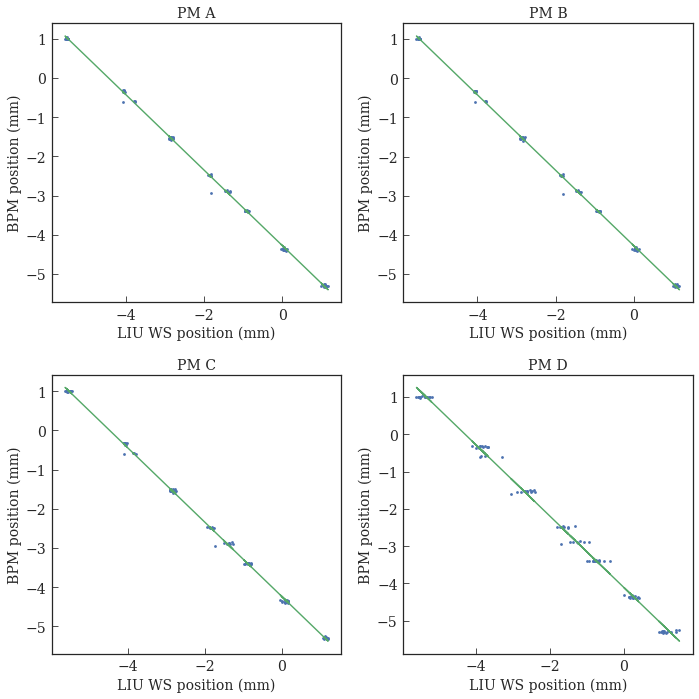

In [37]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

x0 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,3))
yy = myDataFrame['Bump_amplitude']

def print_subplot(ax_obj, row, col, xdata, ydata, title):
    # plotting 
    ax_obj[row,col].set_title(title)
    ax_obj[row,col].plot(xdata, ydata,'.')
    ax_obj[row,col].set_xlabel('LIU WS position (mm)')
    ax_obj[row,col].set_ylabel('BPM position (mm)')
    # fitting 
    popt, pcov = curve_fit(lin, xdata, ydata )
    print(title)
    print(popt, np.sqrt(np.diag(pcov)))
    ax_obj[row,col].plot(xdata, lin(xdata, *popt),'-')

    
print_subplot(ax, 0, 0, x0, yy, 'PM A' )
print_subplot(ax, 0, 1, x1, yy, 'PM B' )
print_subplot(ax, 1, 0, x2, yy, 'PM C' )
print_subplot(ax, 1, 1, x3, yy, 'PM D' )

fig.tight_layout()

# Additional BPMs in the bump


In [89]:
mc = metaclass.twiss('/eos/user/e/esenes/Emittance-measurement-accuracy-precision-study/MADx_bumps_LIU_ws/ps_6.21_6.24.twiss')


Corrector 51 at 316.5592654 m
Corrector 53 at 328.565636 m
Corrector 55 at 340.5720066 m
Corrector 57 at 353.9783772 m

BWS54 at 334.2688213 m

Displacement difference between the BPM54 and the wirescanner is 2.66868e-09 m


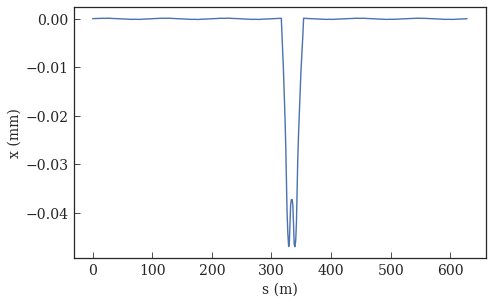

In [90]:
plt.plot(mc.S, 1e3*mc.X)
plt.xlabel('s (m)')
plt.ylabel('x (mm)')
# plt.xlim(300,380)
# plt.ylim(.02,.12)

print('Corrector 51 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BHZ51')[0][0]])+' m')
print('Corrector 53 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BHZ53')[0][0]])+' m')
print('Corrector 55 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BHZ55')[0][0]])+' m')
print('Corrector 57 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BHZ57')[0][0]])+' m')

print('\nBWS54 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BWSH54')[0][0]])+' m\n')


bpmIdx = np.argwhere(np.array(mc.NAME) == 'PR.BPM54')[0][0]
wsIdx = np.argwhere(np.array(mc.NAME) == 'PR.BWSH54')[0][0]
print('Displacement difference between the BPM54 and the wirescanner is '+str(mc.X[bpmIdx]-mc.X[wsIdx]) + ' m')

In [91]:
# other BPMs
print('BPM 53 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BPM53')[0][0]])+' m')
print('BPM 54 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BPM54')[0][0]])+' m')
print('BPM 55 at '+str(mc.S[np.argwhere(np.array(mc.NAME) == 'PR.BPM55')[0][0]])+' m')

bpmIdx = np.argwhere(np.array(mc.NAME) == 'PR.BPM53')[0][0]
wsIdx = np.argwhere(np.array(mc.NAME) == 'PR.BWSH54')[0][0]
print('Displacement difference between the BPM53 and the wirescanner is '+str(mc.X[bpmIdx]-mc.X[wsIdx]) + ' m')
corr53 = mc.X[wsIdx]/mc.X[bpmIdx]

bpmIdx = np.argwhere(np.array(mc.NAME) == 'PR.BPM55')[0][0]
print('Displacement difference between the BPM55 and the wirescanner is '+str(mc.X[bpmIdx]-mc.X[wsIdx]) + ' m')
corr55 = mc.X[wsIdx]/mc.X[bpmIdx]


BPM 53 at 327.565636 m
BPM 54 at 333.6688213 m
BPM 55 at 339.5720066 m
Displacement difference between the BPM53 and the wirescanner is -7.06244259e-06 m
Displacement difference between the BPM55 and the wirescanner is -9.44557565e-06 m


In [92]:
# other BPMs in the bump reported to the BWS location
myDataFrame['Bump_amplitude53'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.mean(x[21, 500:900])*corr53)
myDataFrame['Bump_amplitude55'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.mean(x[23, 500:900])*corr55)


---
PM A
(array([-4.27241952, -0.96074265]), array([ 0.00861655,  0.00298735]))
PM A
(array([-3.00318368, -1.0801009 ]), array([ 0.01461833,  0.00506816]))
PM A
(array([-1.77101034, -1.0426527 ]), array([ 0.01137489,  0.00394366]))
---
PM B
(array([-4.27189108, -0.96127968]), array([ 0.00860547,  0.00298556]))
PM B
(array([-3.00261742, -1.08071884]), array([ 0.01452237,  0.00503836]))
PM B
(array([-1.770449  , -1.04324171]), array([ 0.01131763,  0.00392651]))
---
PM C
(array([-4.23024022, -0.94632839]), array([ 0.00936435,  0.00323133]))
PM C
(array([-2.9558084 , -1.06391856]), array([ 0.01497441,  0.00516718]))
PM C
(array([-1.72520324, -1.02699323]), array([ 0.0121306 ,  0.00418588]))
---
PM D
(array([-4.11193343, -0.95995159]), array([ 0.02159442,  0.0077926 ]))
PM D
(array([-2.82430877, -1.08007385]), array([ 0.02364096,  0.00853112]))
PM D
(array([-1.59778662, -1.04232014]), array([ 0.02246672,  0.00810738]))
---


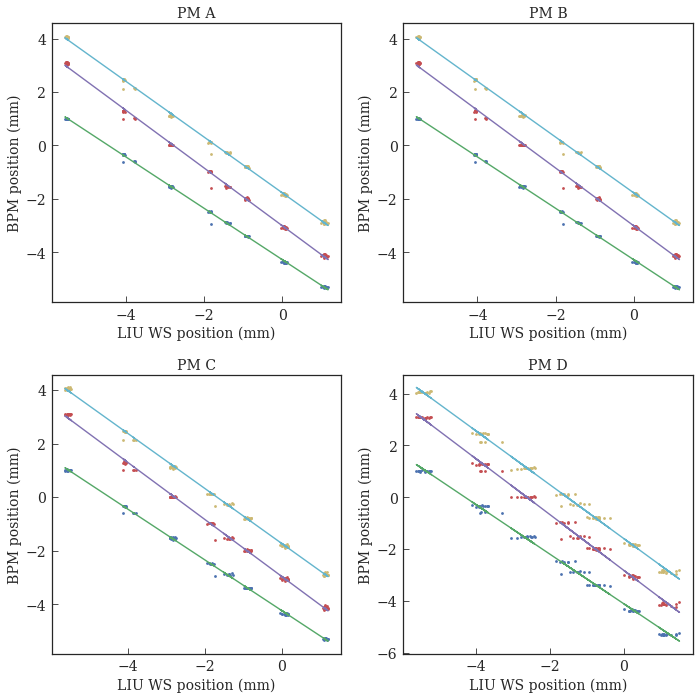

In [93]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

x0 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,3))
yy = myDataFrame['Bump_amplitude']
yy53 = myDataFrame['Bump_amplitude53']
yy55 = myDataFrame['Bump_amplitude55']

def print_subplot(ax_obj, row, col, xdata, ydata, title):
    # plotting 
    ax_obj[row,col].set_title(title)
    ax_obj[row,col].plot(xdata, ydata,'.')
    ax_obj[row,col].set_xlabel('LIU WS position (mm)')
    ax_obj[row,col].set_ylabel('BPM position (mm)')
    # fitting 
    popt, pcov = curve_fit(lin, xdata, ydata )
    print(title)
    print(popt, np.sqrt(np.diag(pcov)))
    ax_obj[row,col].plot(xdata, lin(xdata, *popt),'-')

print('---')    
print_subplot(ax, 0, 0, x0, yy, 'PM A' )
print_subplot(ax, 0, 0, x0, yy53, 'PM A' )
print_subplot(ax, 0, 0, x0, yy55, 'PM A' )
print('---')
print_subplot(ax, 0, 1, x1, yy, 'PM B' )
print_subplot(ax, 0, 1, x1, yy53, 'PM B' )
print_subplot(ax, 0, 1, x1, yy55, 'PM B' )
print('---')
print_subplot(ax, 1, 0, x2, yy, 'PM C' )
print_subplot(ax, 1, 0, x2, yy53, 'PM C' )
print_subplot(ax, 1, 0, x2, yy55, 'PM C' )
print('---')
print_subplot(ax, 1, 1, x3, yy, 'PM D' )
print_subplot(ax, 1, 1, x3, yy53, 'PM D' )
print_subplot(ax, 1, 1, x3, yy55, 'PM D' )
print('---')

fig.tight_layout()

# Export for Jose